# Определение авторства статьи на основе нейронных сете
### Постановка задачи:
* ......
* ......

In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D
import numpy as np
import pandas as pd
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


### Загрузка тестовых документов

In [2]:
path = 'D:\Разработка\DataScience\Habrahabr'
files = os.listdir(path)
data_frame = pd.DataFrame()

for file_name in files:
    file_obj = codecs.open(path + '\\' + file_name, "r", "utf_8_sig" )
    file_temp = file_obj.read()
    url = file_temp[file_temp.find('url:') + 5:file_temp.find('title:')].rstrip()
    title = file_temp[file_temp.find('title:') + 7:file_temp.find('text:')].rstrip()
    text = file_temp[file_temp.find('text:') + 5:file_temp.find('author:')].rstrip()
    author = file_temp[file_temp.find('author:') + 8:].rstrip()
    row = pd.Series([url, title, text, author], index=['Url', 'Title', 'Text', 'Author'])
    data_frame = data_frame.append(row, ignore_index=True)
    file_obj.close()

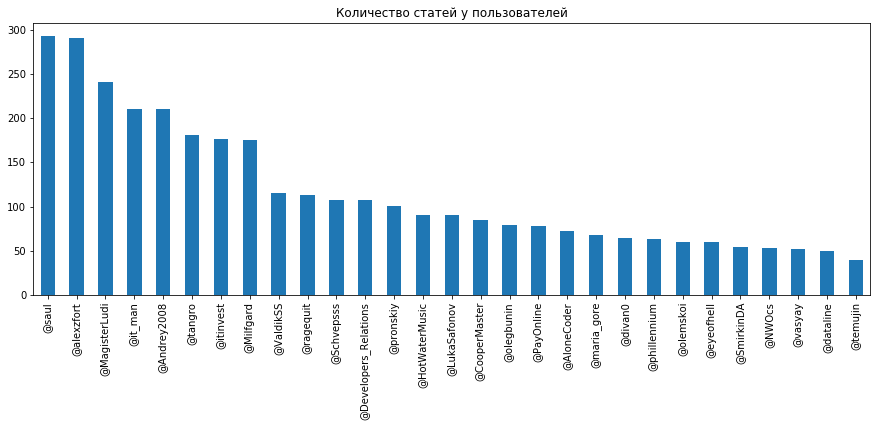

In [3]:
author_count_news = data_frame.Author.value_counts()[1:30]
author_count_news.plot(kind='bar', figsize=(15, 5), title='Количество статей у пользователей')

### Подготовка данных для анализа
- Добавление только топ 30 авторов
- Удаление столбцов URL, Title
- One hot encoding для результирующей выборки

In [4]:
data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    data = data.append(data_frame[data_frame.Author == author])

oneHotEnc = OneHotEncoder()
lableEnc = LabelEncoder()

lableEnc.fit(names_author.ravel()) 
lables = lableEnc.transform(names_author).reshape((29, 1))
oneHotEnc.fit(lables)

#aaa = lableEnc.transform(['@saul'])
#vvv = oneHotEnc.transform(aaa).toarray()
#print(vvv)

for author in names_author:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data = data.drop(['Url', 'Title'], axis=1)
data.head()

,Author,Text
2227,25,"В шестой части серии учебных материалов, посв..."
2228,25,"Intel Xeon Phi— уникальный процессор, как ник..."
2229,25,"В пятой части серии учебных материалов, посвя..."
2230,25,В нашем беспокойном мире забота о собственной...
2231,25,"Когда год назад в отчетном постемы писали, чт..."


### Производим векторизацию текста с помощью TF-IDF

In [5]:
texts = data['Text']
max_features = 500
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r', split=" ", lower=True)
tokenizer.fit_on_texts(texts)
matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
print(matrix_tfidf.shape)

(3381, 500)


### Создание модели нейронной сети

In [6]:
model = Sequential()
# Слой для векторного представления слов
model.add(Embedding(max_features, 32))
model.add(SpatialDropout1D(0.2))
# Слой долго-краткосрочной памяти
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
# Полносвязный слой
model.add(Dense(29, activation="sigmoid"))
# Копмилируем модель
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
X_train = matrix_tfidf
y_train = oneHotEnc.transform(data.Author.values.reshape(-1, 1)).toarray()

model.fit(X_train, y_train, batch_size=64, epochs=7, verbose=2, shuffle=True)
# Проверяем качество обучения на тестовых данных
scores = model.evaluate(X_train, y_train, batch_size=64)
print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

Epoch 1/7
80s - loss: 0.3001 - acc: 0.9291
Epoch 2/7
83s - loss: 0.1447 - acc: 0.9655
Epoch 3/7
81s - loss: 0.1445 - acc: 0.9655
Epoch 4/7
77s - loss: 0.1445 - acc: 0.9655
Epoch 5/7
81s - loss: 0.1444 - acc: 0.9655
Epoch 6/7
75s - loss: 0.1445 - acc: 0.9655
Epoch 7/7
74s - loss: 0.1444 - acc: 0.9655
3381/3381 [==============================] - 21s    
Точность на тестовых данных: 96.55%
